In [ ]:
!pip install transformers[torch] scikit-learn datasets adabelief-pytorch==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import ConvBertTokenizer,BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from torch.optim import Adam, RAdam
from adabelief_pytorch import AdaBelief
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [ ]:
# Set CUDA_LAUNCH_BLOCKING for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# Load your dataset
df = pd.read_csv('text_class_sonuc_cikarilmis.csv')  # Adjust the file name/path accordingly
new_df = pd.concat([df[df["class"] == 1].sample(400,replace=True),df],axis=0)
new_df = pd.concat([df[df["class"] == 2].sample(100,replace=True),df],axis=0)
texts = new_df['text'].tolist()
labels = new_df['class'].tolist()
# texts = df['text'].tolist()
# labels = df['class'].tolist()

# Convert labels to integers if they are not already
labels = [int(label)-1 for label in labels]

# Ensure labels are within the correct range
num_labels = 5
# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.1,random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2,random_state=42)
# train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2,random_state=42)
# train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.2,random_state=42)

In [ ]:
model_name = "dbmdz/convbert-base-turkish-cased"

In [ ]:
# Load the BERT tokenizer
tokenizer = ConvBertTokenizer.from_pretrained(model_name)

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)
# Create a custom dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Create train and validation datasets
train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)
test_dataset = Dataset(test_encodings,test_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

In [ ]:
# Define the compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [ ]:
# Load the BERT model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of ConvBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/convbert-base-turkish-cased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvBertForSequenceClassification(
  (convbert): ConvBertModel(
    (embeddings): ConvBertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ConvBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x ConvBertLayer(
          (attention): ConvBertAttention(
            (self): ConvBertSelfAttention(
              (query): Linear(in_features=768, out_features=384, bias=True)
              (key): Linear(in_features=768, out_features=384, bias=True)
              (value): Linear(in_features=768, out_features=384, bias=True)
              (key_conv_attn_layer): SeparableConv1D(
                (depthwise): Conv1d(768, 768, kernel_size=(9,), stride=(1,), padding=(4,), groups=768, bias=False)
                (pointwise): Conv1d(7

In [ ]:
# Define training arguments
epoch_num = 20
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epoch_num,
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    #weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # Set to True since higher F1 score is better
    save_total_limit=1,
)
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=15,
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=10,
#     evaluation_strategy="epoch",
# )


# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer.optimizer = AdaBelief(model.parameters(), eps=1e-16,lr=5e-5,rectify=False,weight_decouple=False)
# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.304300,1.029321,0.629630,0.603075,0.633056,0.629630
2,0.728700,0.627344,0.783069,0.771828,0.763604,0.783069
3,0.437600,0.426437,0.867725,0.852361,0.841764,0.867725
4,0.349100,0.247275,0.925926,0.912786,0.900756,0.925926
5,0.183200,0.228051,0.920635,0.913309,0.924745,0.920635
6,0.073000,0.165577,0.957672,0.957704,0.960372,0.957672
7,0.054900,0.172701,0.955026,0.954926,0.957530,0.955026
8,0.033800,0.086327,0.978836,0.978819,0.979145,0.978836
9,0.044200,0.286939,0.949735,0.948968,0.954446,0.949735
10,0.003800,0.112713,0.976190,0.976041,0.976798,0.976190


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

TrainOutput(global_step=960, training_loss=0.17228839863382744, metrics={'train_runtime': 834.5891, 'train_samples_per_second': 36.233, 'train_steps_per_second': 1.15, 'total_flos': 3829193785589760.0, 'train_loss': 0.17228839863382744, 'epoch': 20.0})

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.18266934156417847,
 'eval_accuracy': 0.9666666666666667,
 'eval_f1': 0.9663590906448051,
 'eval_precision': 0.9665656565656565,
 'eval_recall': 0.9666666666666667,
 'eval_runtime': 1.6979,
 'eval_samples_per_second': 123.681,
 'eval_steps_per_second': 4.123,
 'epoch': 20.0}

In [ ]:
model.save_pretrained(f"drive/MyDrive/text_classifier__dbmdz_convbert__{epoch_num}epoch_0966_AdaBelief_250test")

# AŞAĞIDAKİLER TEST DATASINI AYIRMADAN SADECE TRAIN VE VALIDATION ÜZERİNDEN EVAL_F1 SKORU

### dbmdz/bert-base-turkish-cased
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)
**'eval_f1': 0.8280576533281807,**

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=13,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)
**'eval_f1': 0.969174630026934,**

### dbmdz/convbert-base-turkish-cased
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)
**'eval_f1': 0.915546,**

### alierenak/berturk_cased_sentiment
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)
**'eval_f1': 0.9296781306041138,**

### coltekin/berturk-tremo 20 epoch 0.85 fln

### google-bert/bert-base-multilingual-cased 20 epoch 0.82 fln

# TEST DATASINI AYIRDIKTAN SONRA TEST'İN F1 SKORLARI

### dbmdz/bert-base-turkish-cased (15 + 15 Epoch)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)
**'eval_f1': 0.934023930611725**

batch_size'ı 32 yaptım, learning_rate i 5e-5 yaptım

**'eval_f1': 0.9530322679607318,**

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)
**trainer.optimizer = Adam(model.parameters(), lr=5e-5)**
  
{'eval_loss': 0.2890544533729553,
 'eval_accuracy': 0.953125,
 **'eval_f1': 0.9531228734858409,**
 'eval_precision': 0.9535915882929016,
 'eval_recall': 0.953125,
 'eval_runtime': 2.1281,
 'eval_samples_per_second': 150.367,
 'eval_steps_per_second': 4.699,
 'epoch': 15.0}

In [ ]:
model_loaded = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/text_classifier__dbmdz_convbert__15epoch_0956_ADAMW",num_labels=5)

In [ ]:
trainer_temp = Trainer(
    model=model_loaded,
    compute_metrics=compute_metrics,
)
trainer_temp.evaluate(test_dataset)

{'eval_loss': 0.29203662276268005,
 'eval_accuracy': 0.95625,
 'eval_f1': 0.955984745661085,
 'eval_precision': 0.9565463238662393,
 'eval_recall': 0.95625,
 'eval_runtime': 2.9533,
 'eval_samples_per_second': 108.352,
 'eval_steps_per_second': 13.544}

Confusion Matrix:
[[ 7  1  0  0  1]
 [ 0 56  1  1  0]
 [ 0  2 83  0  2]
 [ 0  0  1 92  0]
 [ 0  0  0  1 72]]


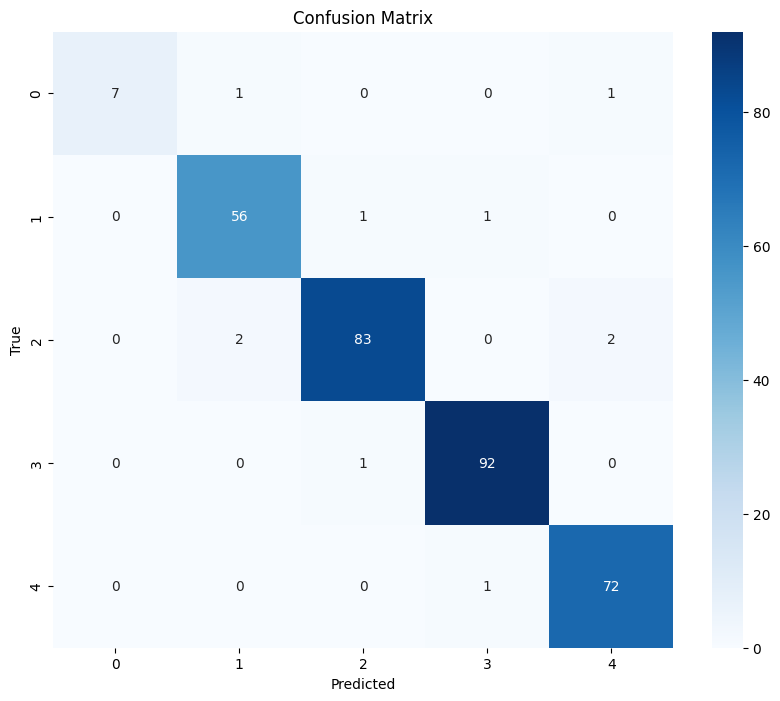

              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.95      0.97      0.96        58
           2       0.98      0.95      0.97        87
           3       0.98      0.99      0.98        93
           4       0.96      0.99      0.97        73

    accuracy                           0.97       320
   macro avg       0.97      0.93      0.95       320
weighted avg       0.97      0.97      0.97       320



In [ ]:
# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_labels), yticklabels=range(num_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(test_labels, preds))

### dbmdz/convbert-base-turkish-cased

**ADAM**
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)
**trainer.optimizer = Adam(model.parameters(), lr=5e-5)**
{'eval_loss': 0.2328832596540451,
 'eval_accuracy': 0.959375,
**'eval_f1': 0.9597885410711371,**
 'eval_precision': 0.9613667115539272,
 'eval_recall': 0.959375,
 'eval_runtime': 2.5537,
 'eval_samples_per_second': 125.309,
 'eval_steps_per_second': 3.916,
 'epoch': 15.0}

**ADAMW**
{'eval_loss': 0.29203662276268005,
 'eval_accuracy': 0.95625,
 **'eval_f1': 0.955984745661085,**
 'eval_precision': 0.9565463238662393,
 'eval_recall': 0.95625,
 'eval_runtime': 2.9533,
 'eval_samples_per_second': 108.352,
 'eval_steps_per_second': 13.544}

**trainer.optimizer = AdaBelief(model.parameters(), eps=1e-16,lr=5e-5,rectify=False,weight_decouple=False)**

{'eval_loss': 0.22038984298706055,
 'eval_accuracy': 0.96875,
 **'eval_f1': 0.9684266631807457,**
 'eval_precision': 0.9690783288432574,
 'eval_recall': 0.96875,
 'eval_runtime': 2.6131,
 'eval_samples_per_second': 122.458,
 'eval_steps_per_second': 3.827,
 'epoch': 20.0}
